In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

In [39]:
# Load the datasets
train_data = pd.read_csv('/Users/shivatmaksharma/D/Uni Work/FDA/Assignment 3/loan_data_training-2.csv')
test_data = pd.read_csv('/Users/shivatmaksharma/D/Uni Work/FDA/Assignment 3/loan_data_unknown.csv')

**Exploratory Data Analysis**

In [30]:
# Display the DataFrame's information (data types, non-null counts, memory usage, etc.)
print("\nDataFrame Information:")
print(train_data.info())

# Display statistics for numerical columns
print("\nStatistics for Numerical Columns:")
print(train_data.describe())

# Display statistics for categorical columns
print("\nStatistics for Categorical Columns:")
print(train_data.describe(include=['object']))

# Checking for missing values
print("\nMissing Values:")
print(train_data.isnull().sum())

# Checking the number of unique values in each column
print("\nUnique Values in Each Column:")
print(train_data.nunique())


DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42452 entries, 0 to 42451
Data columns (total 72 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SK_ID_CURR                   42452 non-null  int64  
 1   TARGET                       42452 non-null  int64  
 2   NAME_CONTRACT_TYPE           42452 non-null  object 
 3   CODE_GENDER                  42452 non-null  object 
 4   FLAG_OWN_CAR                 42452 non-null  object 
 5   FLAG_OWN_REALTY              42452 non-null  object 
 6   CNT_CHILDREN                 42452 non-null  int64  
 7   AMT_INCOME_TOTAL             42452 non-null  float64
 8   AMT_CREDIT                   42452 non-null  float64
 9   AMT_ANNUITY                  42451 non-null  float64
 10  AMT_GOODS_PRICE              42404 non-null  float64
 11  NAME_TYPE_SUITE              42293 non-null  object 
 12  NAME_INCOME_TYPE             42452 non-null  objec

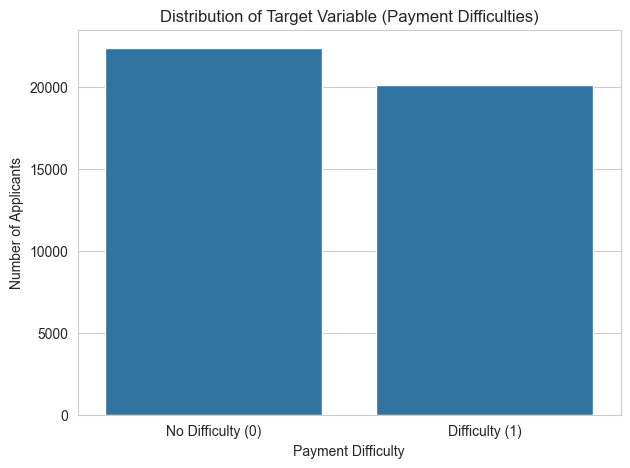

TARGET
0    52.631207
1    47.368793
Name: proportion, dtype: float64

In [129]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Univariate analysis on the target variable
plt.figure(figsize=(7, 5))
sns.countplot(data=train_data, x='TARGET')
plt.title('Distribution of Target Variable (Payment Difficulties)')
plt.xlabel('Payment Difficulty')
plt.ylabel('Number of Applicants')
plt.xticks([0, 1], ['No Difficulty (0)', 'Difficulty (1)'])
plt.show()

# Calculate the percentage of each class in the target variable
target_counts = train_data['TARGET'].value_counts(normalize=True) * 100

target_counts

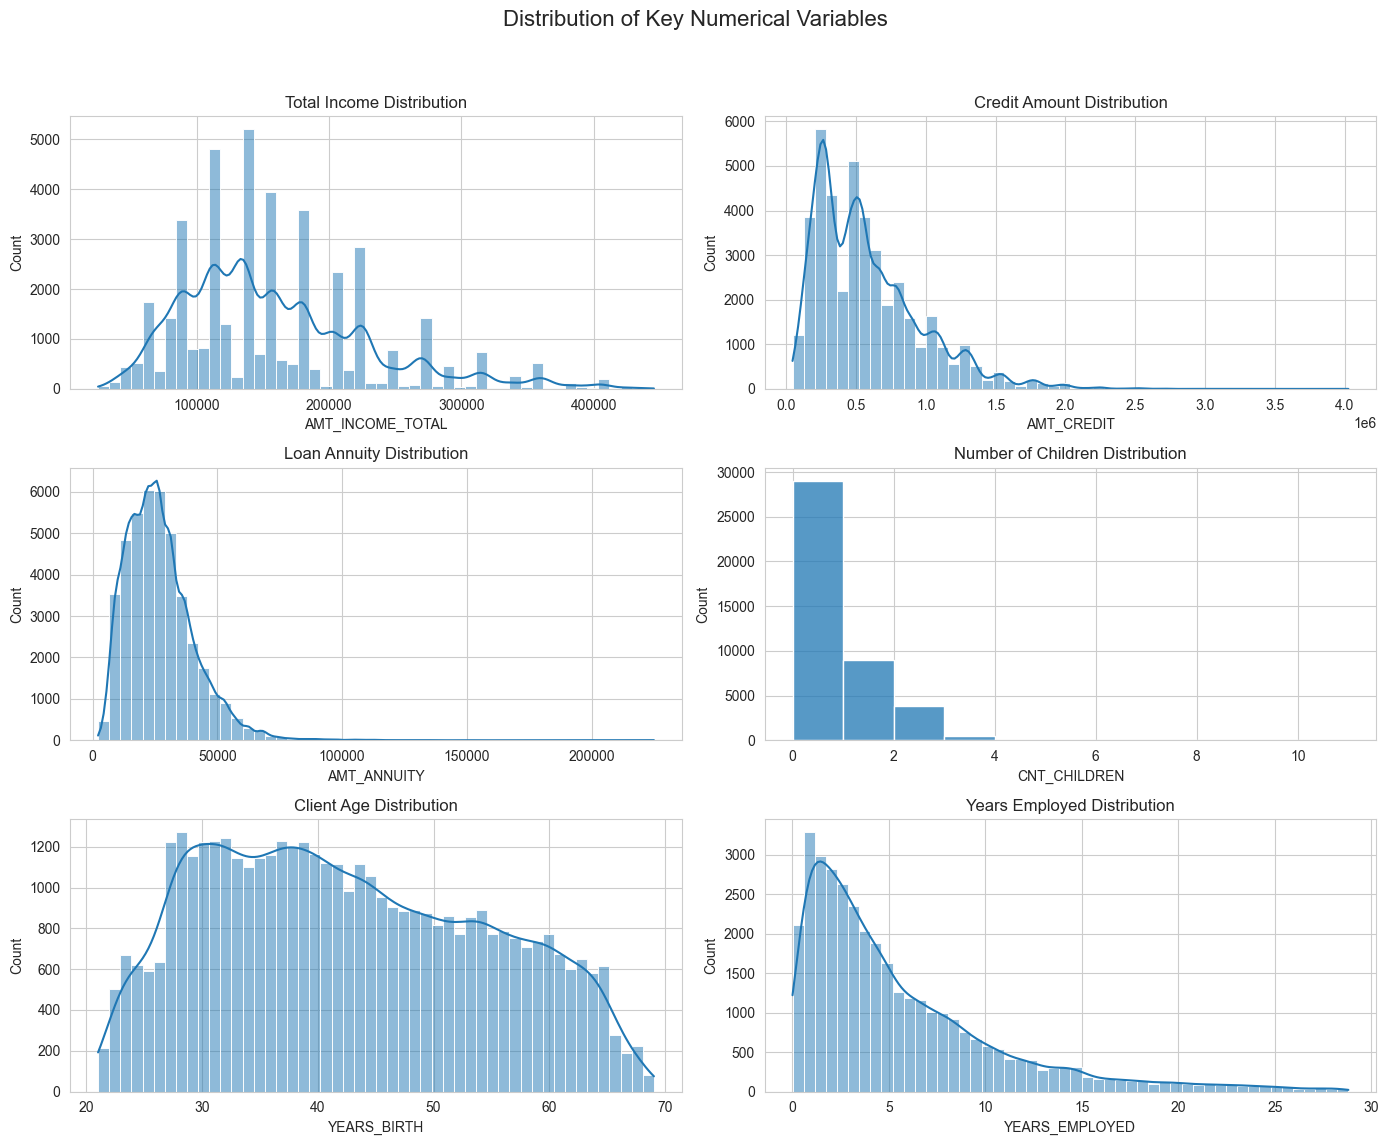

In [133]:
# Convert DAYS_BIRTH from days to years for better interpretation
train_data['YEARS_BIRTH'] = train_data['DAYS_BIRTH'] / -365

# Convert DAYS_EMPLOYED from days to years for better interpretation
# There might be anomalies in DAYS_EMPLOYED (like very high positive values), so we need to handle them
train_data['YEARS_EMPLOYED'] = train_data['DAYS_EMPLOYED'].apply(lambda x: x / -365 if x < 0 else None)

# Plot histograms for the chosen variables
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
fig.suptitle('Distribution of Key Numerical Variables', fontsize=16)

# Plotting 'AMT_INCOME_TOTAL' with a cap to remove extreme outliers for visualization purposes
sns.histplot(train_data[train_data['AMT_INCOME_TOTAL'] < train_data['AMT_INCOME_TOTAL'].quantile(0.99)], 
             x='AMT_INCOME_TOTAL', bins=50, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Total Income Distribution')

# Plotting 'AMT_CREDIT'
sns.histplot(train_data, x='AMT_CREDIT', bins=50, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Credit Amount Distribution')

# Plotting 'AMT_ANNUITY'
sns.histplot(train_data, x='AMT_ANNUITY', bins=50, ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Loan Annuity Distribution')

# Plotting 'CNT_CHILDREN'
sns.histplot(train_data, x='CNT_CHILDREN', bins=range(0, train_data['CNT_CHILDREN'].max() + 1), ax=axes[1, 1], kde=False)
axes[1, 1].set_title('Number of Children Distribution')

# Plotting 'YEARS_BIRTH'
sns.histplot(train_data, x='YEARS_BIRTH', bins=50, ax=axes[2, 0], kde=True)
axes[2, 0].set_title('Client Age Distribution')

# Plotting 'YEARS_EMPLOYED' with a cap to remove anomalies for visualization purposes
sns.histplot(train_data[train_data['YEARS_EMPLOYED'] < train_data['YEARS_EMPLOYED'].quantile(0.99)], 
             x='YEARS_EMPLOYED', bins=50, ax=axes[2, 1], kde=True)
axes[2, 1].set_title('Years Employed Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the padding between and around subplots
plt.show()


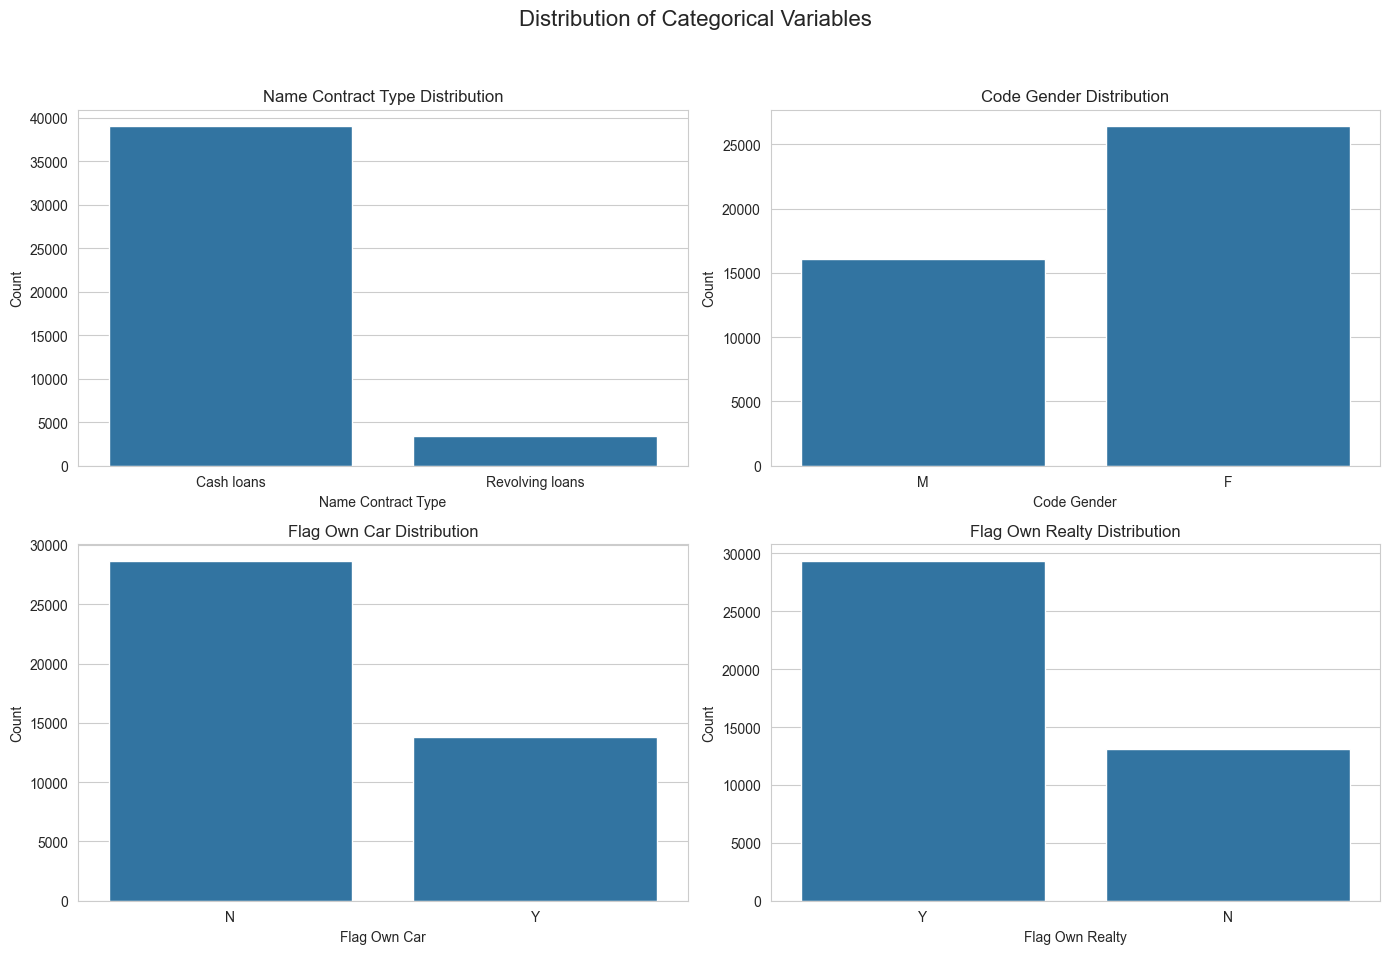

In [134]:
# Select categorical variables for analysis
categorical_cols = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

# Plotting the distributions of categorical variables
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('Distribution of Categorical Variables', fontsize=16)

# Loop through the selected categorical columns and create a count plot for each
for i, col in enumerate(categorical_cols):
    row = i // 2
    col_pos = i % 2
    sns.countplot(data=train_data, x=col, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(col.replace('_', ' ').title() + ' Distribution')
    axes[row, col_pos].set_xlabel(col.replace('_', ' ').title())
    axes[row, col_pos].set_ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the padding between and around subplots
plt.show()


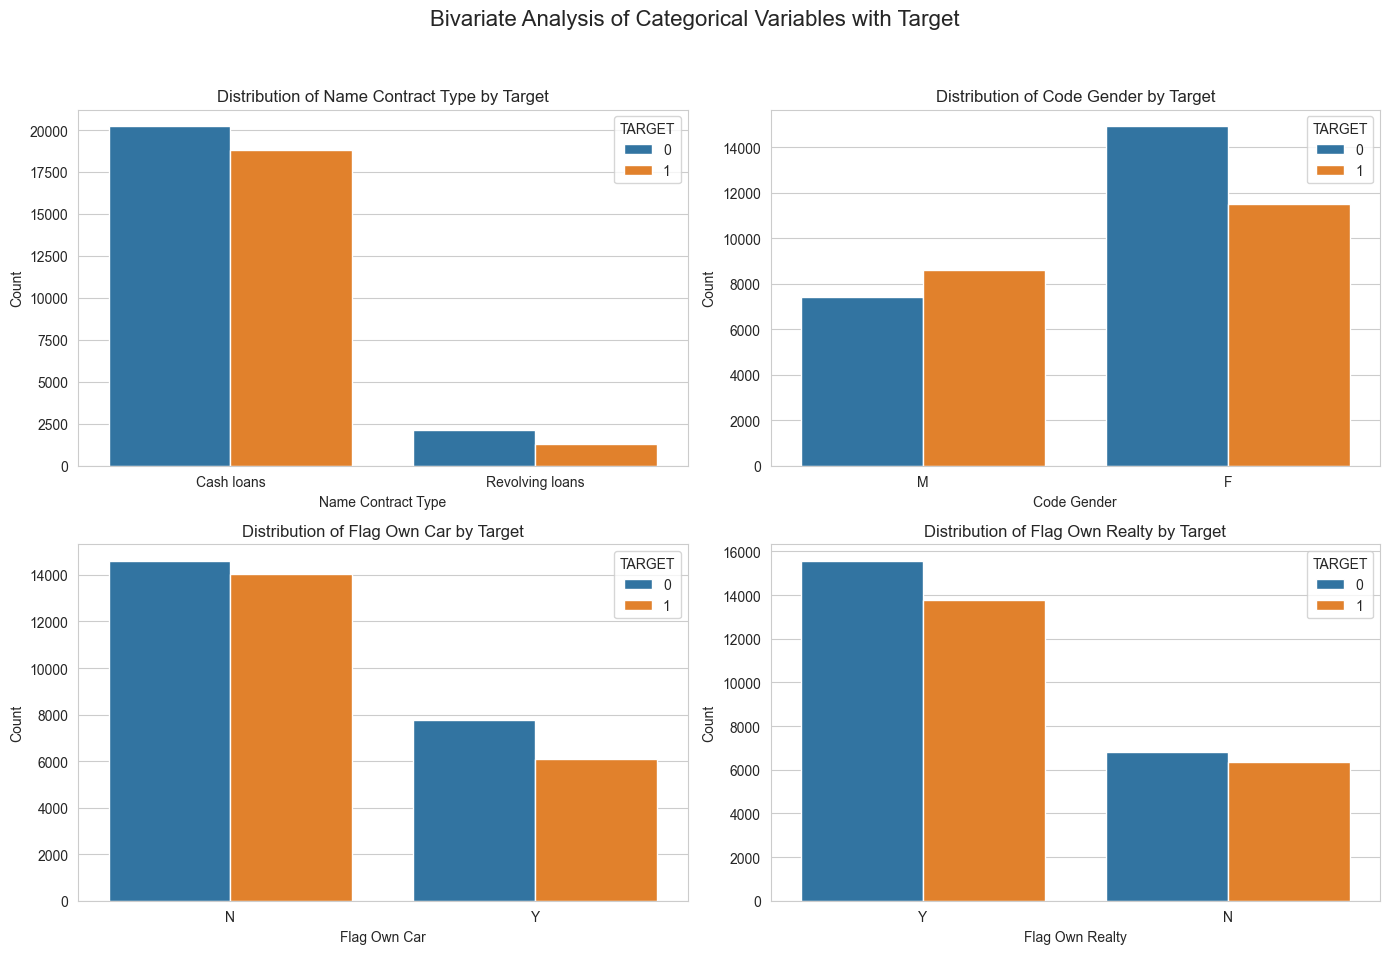

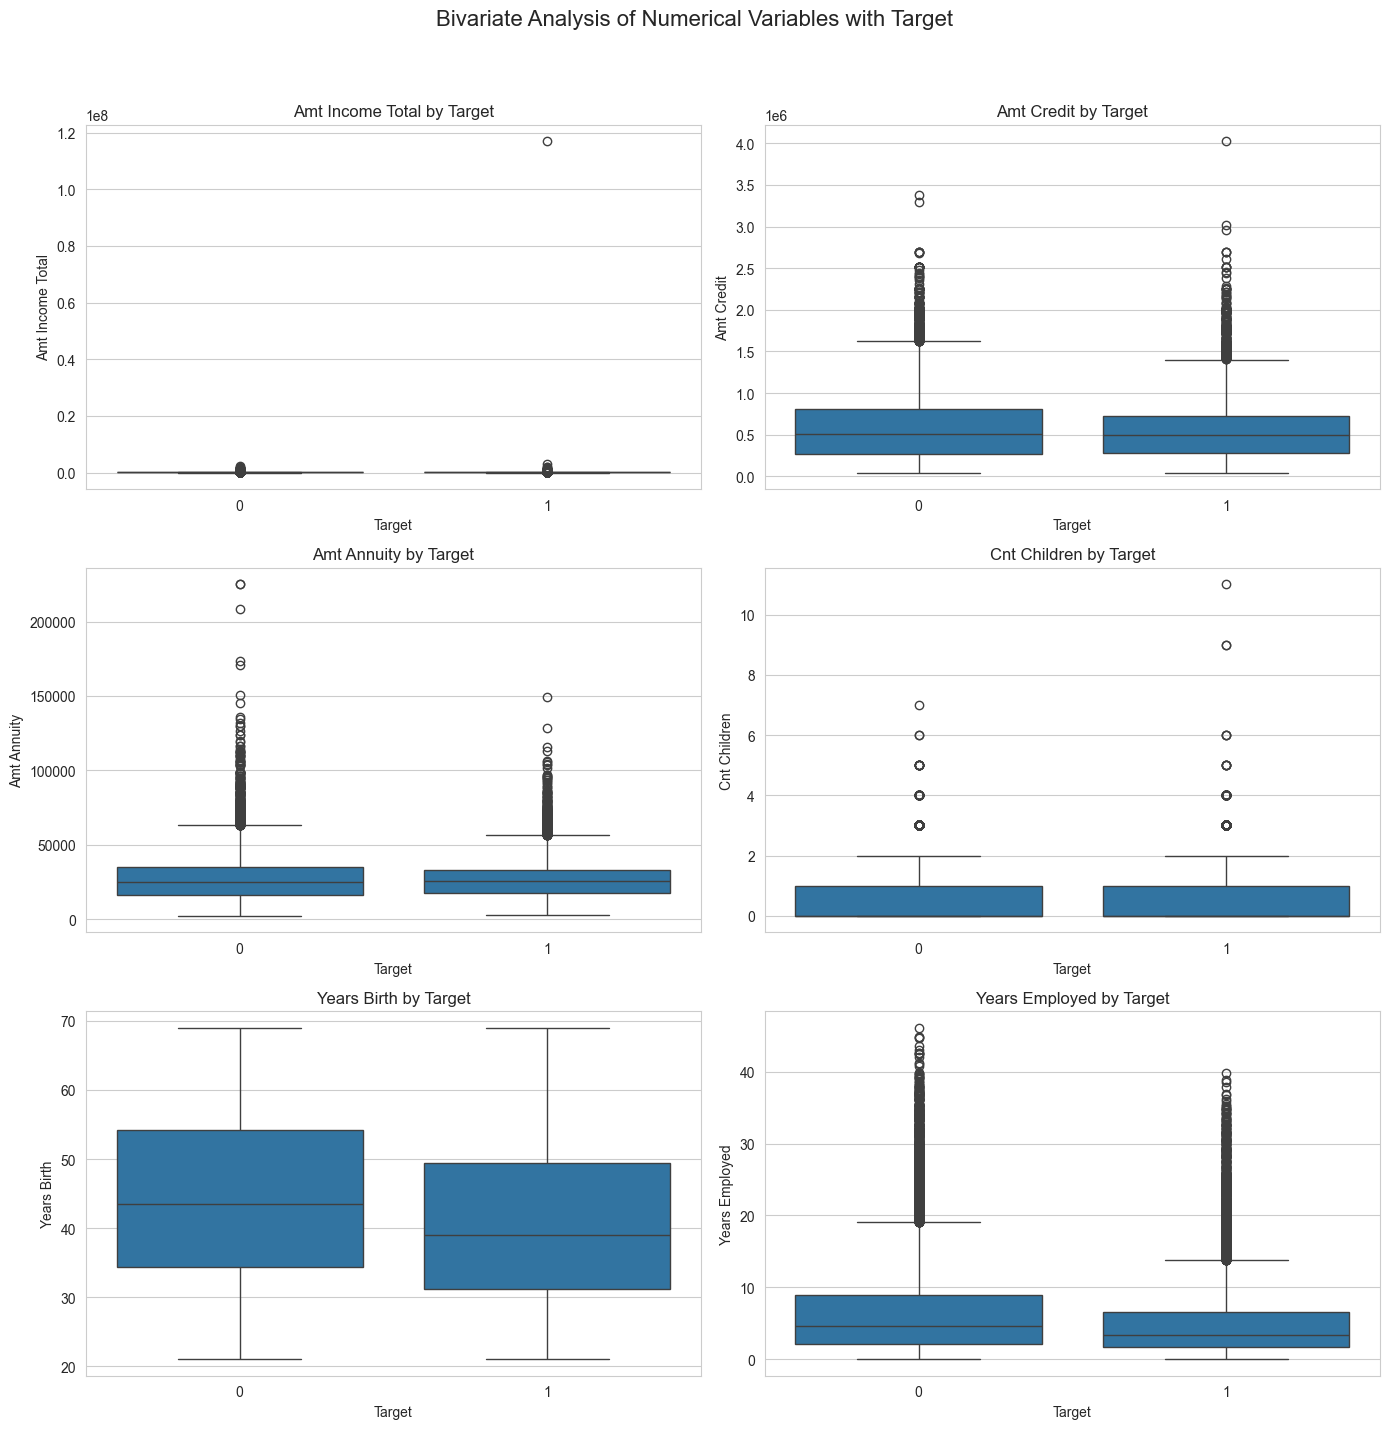

In [140]:
# Bivariate analysis on categorical variables with respect to the target variable
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('Bivariate Analysis of Categorical Variables with Target', fontsize=16)

# Loop through the selected categorical columns and create a count plot for each
for i, col in enumerate(categorical_cols):
    row = i // 2
    col_pos = i % 2
    sns.countplot(data=train_data, x=col, hue='TARGET', ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'Distribution of {col.replace("_", " ").title()} by Target')
    axes[row, col_pos].set_xlabel(col.replace('_', ' ').title())
    axes[row, col_pos].set_ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the padding between and around subplots
plt.show()

# Bivariate analysis on numerical variables with respect to the target variable using box plots
numerical_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'CNT_CHILDREN', 'YEARS_BIRTH', 'YEARS_EMPLOYED']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15))
fig.suptitle('Bivariate Analysis of Numerical Variables with Target', fontsize=16)

# Loop through the selected numerical columns and create a box plot for each
for i, col in enumerate(numerical_cols):
    row = i // 2
    col_pos = i % 2
    sns.boxplot(data=train_data, y=col, x='TARGET', ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'{col.replace("_", " ").title()} by Target')
    axes[row, col_pos].set_xlabel('Target')
    axes[row, col_pos].set_ylabel(col.replace('_', ' ').title())

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the padding between and around subplots
plt.show()


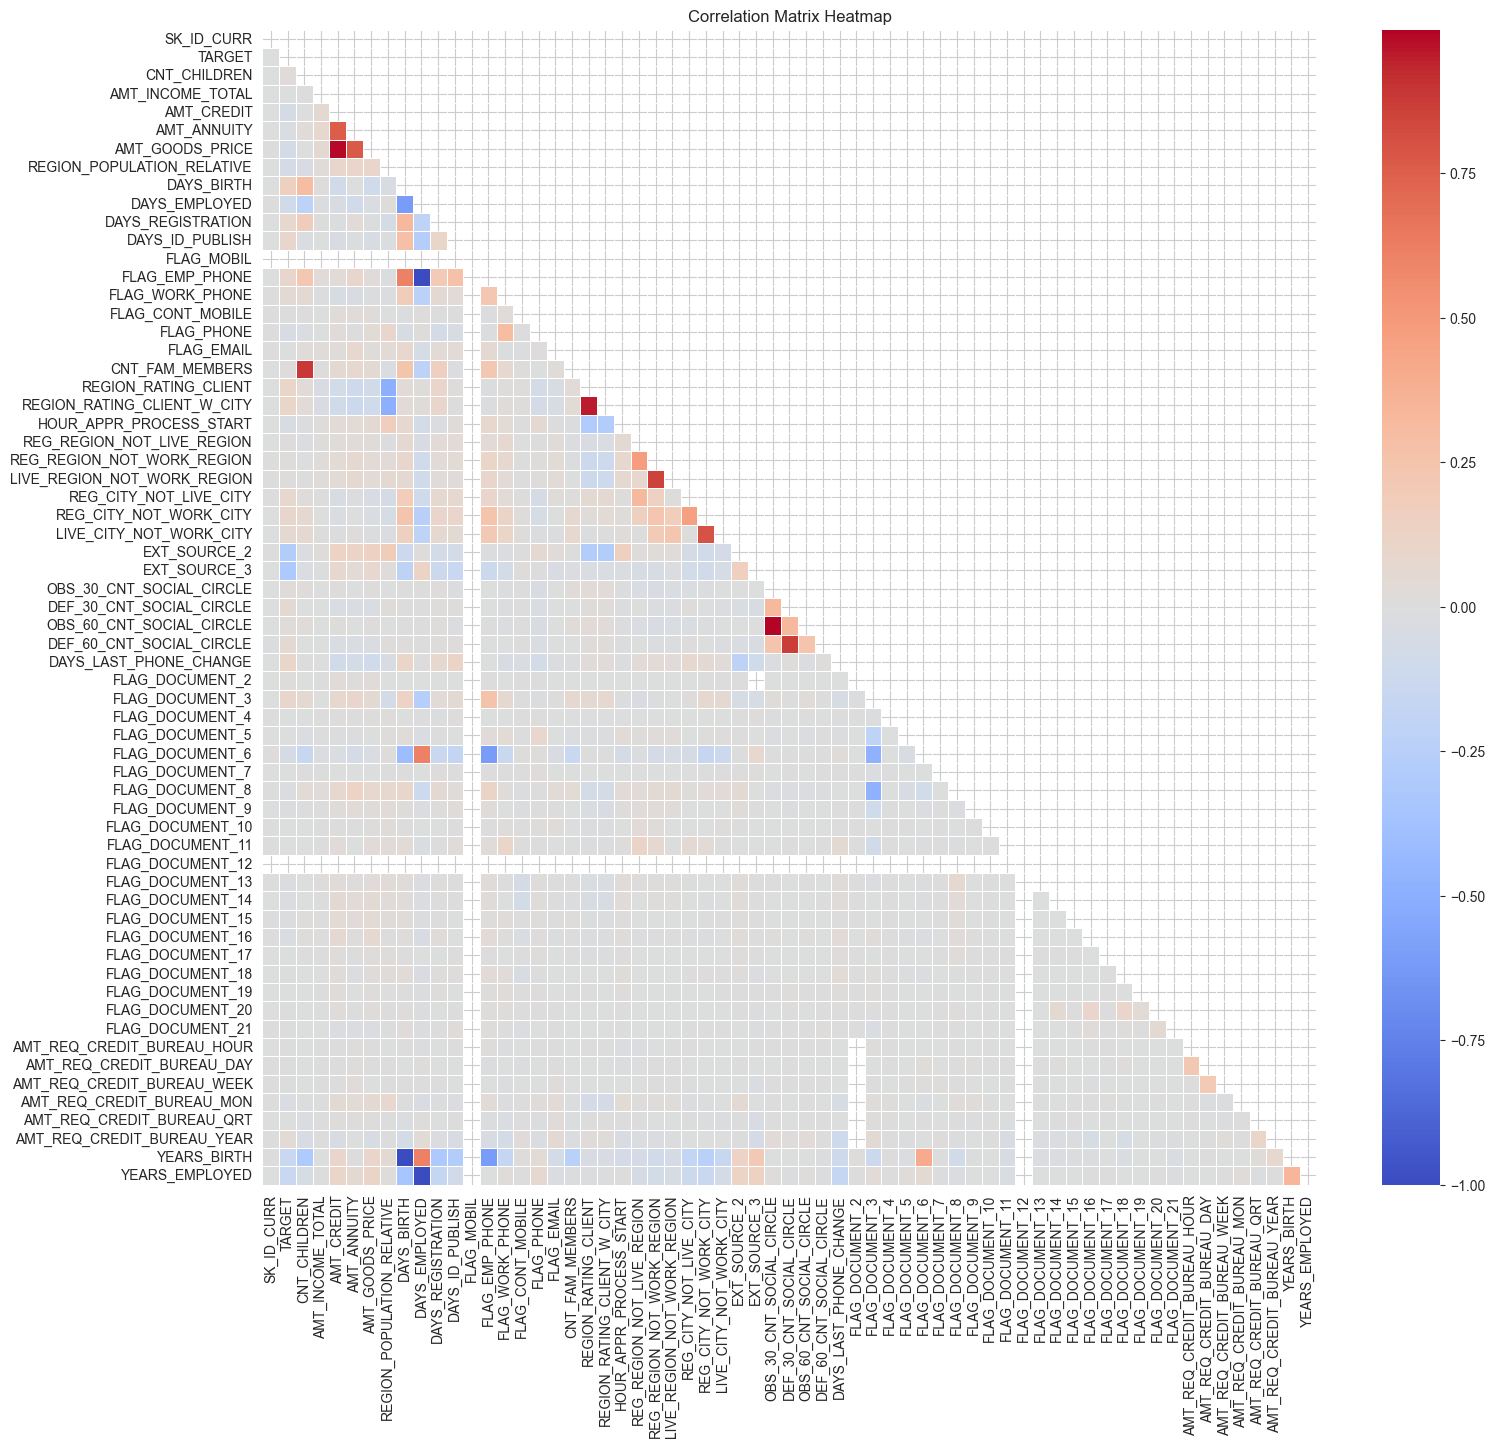

In [138]:
# Select only the numeric columns for the correlation matrix
numeric_train_data = train_data.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_train_data.corr()

# Use a mask to display only one triangle of the corr matrix since it's mirrored across the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(17, 15))

# Draw the heatmap with the mask
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', linewidths=.5, fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


**Pre-Processing the Data**

In [318]:
def preprocess_data(data, scaler_obj=None, train_columns=None):
    # Convert DAYS_BIRTH to age in years
    data['AGE_YEARS'] = (-data['DAYS_BIRTH'] / 365).astype(int)
    
    # Convert DAYS_EMPLOYED, DAYS_REGISTRATION, and DAYS_ID_PUBLISH to positive values and into years
    data['YEARS_EMPLOYED'] = (-data['DAYS_EMPLOYED'] / 365).astype(int)
    data['YEARS_REGISTRATION'] = (-data['DAYS_REGISTRATION'] / 365).astype(int)
    data['YEARS_ID_PUBLISH'] = (-data['DAYS_ID_PUBLISH'] / 365).astype(int)

    # Create CREDIT_INCOME_RATIO feature
    data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
    # Create Credit to Goods Price Ratio
    data['CREDIT_GOODS_PRICE_RATIO'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
    # Create Annuity to Income Ratio
    data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
    # Income per Family Member
    data['INCOME_PER_FAMILY_MEMBER'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
    # Social Circle Default Ratio for 30 days
    data['SOCIAL_CIRCLE_30D_DEFAULT_RATIO'] = data['DEF_30_CNT_SOCIAL_CIRCLE'] / (data['OBS_30_CNT_SOCIAL_CIRCLE'] + 0.001)  # added 0.001 to avoid division by zero
    # Social Circle Default Ratio for 60 days
    data['SOCIAL_CIRCLE_60D_DEFAULT_RATIO'] = data['DEF_60_CNT_SOCIAL_CIRCLE'] / (data['OBS_60_CNT_SOCIAL_CIRCLE'] + 0.001)
    # External Source Average
    data['EXT_SOURCE_AVG'] = data[['EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    # Total Documents Submitted
    doc_cols = [col for col in data.columns if 'FLAG_DOCUMENT' in col]
    data['TOTAL_DOCUMENTS_SUBMITTED'] = data[doc_cols].sum(axis=1)
    # Total Credit Bureau Enquiries
    bureau_cols = [col for col in data.columns if 'AMT_REQ_CREDIT_BUREAU' in col]
    data['TOTAL_BUREAU_ENQUIRIES'] = data[bureau_cols].sum(axis=1)
    # Days since Last Change in Months
    data['MONTHS_SINCE_LAST_PHONE_CHANGE'] = (-data['DAYS_LAST_PHONE_CHANGE'] / 30).astype(int)

    # Dropping the original days columns as we have converted them to more meaningful columns
    data = data.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE'])

    # Handling missing values
    for column in data.select_dtypes(include=['float64', 'int64']):
        data[column].fillna(data[column].median(), inplace=True)
    for column in data.select_dtypes(include=['object']):
        data[column].fillna(data[column].mode()[0], inplace=True)

    # Separate TARGET before scaling
    y = None
    if 'TARGET' in data:
        y = data['TARGET']
        data = data.drop(['TARGET'], axis=1)

    # One-hot Encoding
    data_encoded = pd.get_dummies(data, drop_first=True)

    # Ensure the test dataset has the same columns as the training dataset
    if train_columns is not None:
        missing_cols = set(train_columns) - set(data_encoded.columns)
        for column in missing_cols:
            data_encoded[column] = 0
        data_encoded = data_encoded[train_columns]

    # Scaling
    if not scaler_obj:
        scaler_obj = StandardScaler()
        data_scaled = pd.DataFrame(scaler_obj.fit_transform(data_encoded), columns=data_encoded.columns)
    else:
        data_scaled = pd.DataFrame(scaler_obj.transform(data_encoded), columns=data_encoded.columns)

    return data_scaled, y, scaler_obj, data_encoded.columns


In [319]:
# Processing the training dataset
X_train_full, y_train_full, scaler, train_cols = preprocess_data(train_data)

# Drop 'SK_ID_CURR' from X_train_full
X_train_full = X_train_full.drop(['SK_ID_CURR'], axis=1, errors='ignore')

# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

# Process the test dataset using the same scaler and column order
X_test, y_test, _, _ = preprocess_data(test_data, scaler, train_cols)


**Logistic Regression**

In [153]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming X_train and y_train are already defined and preprocessed for the full feature set
# Also assuming that X_val and y_val are the validation sets prepared from the full feature set

# Initialize and train the logistic regression model on the full set of features
logreg_full = LogisticRegression(max_iter=1000, random_state=42)
logreg_full.fit(X_train, y_train)

# Predict on the validation set using the full feature model
y_val_pred_full = logreg_full.predict(X_val)

# Evaluate the model with the full set of features
accuracy_full = accuracy_score(y_val, y_val_pred_full)
precision_full = precision_score(y_val, y_val_pred_full)
recall_full = recall_score(y_val, y_val_pred_full)
f1_full = f1_score(y_val, y_val_pred_full)

# Output the performance
print(f'Full Feature Set Accuracy: {accuracy_full}')
print(f'Full Feature Set Precision: {precision_full}')
print(f'Full Feature Set Recall: {recall_full}')
print(f'Full Feature Set F1 Score: {f1_full}')


Full Feature Set Accuracy: 0.6765987516193617
Full Feature Set Precision: 0.6686938127974617
Full Feature Set Recall: 0.6287916459472899
Full Feature Set F1 Score: 0.6481291645310097


In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming X_train and y_train are already defined and preprocessed

# Initialize and train the logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Get the absolute values of the coefficients
feature_importance = abs(logreg.coef_[0])

# Create a DataFrame for visualization
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select the top N features (e.g., top 10)
N = 10
top_features = importance_df['Feature'].iloc[:N].tolist()

# Retrain the model with top N features
X_train_top_features = X_train[top_features]
X_val_top_features = X_val[top_features]

logreg_top_features = LogisticRegression(max_iter=1000, random_state=42)
logreg_top_features.fit(X_train_top_features, y_train)

# Predict and evaluate the model with top N features
y_val_pred_top_features = logreg_top_features.predict(X_val_top_features)
accuracy = accuracy_score(y_val, y_val_pred_top_features)
precision = precision_score(y_val, y_val_pred_top_features)
recall = recall_score(y_val, y_val_pred_top_features)
f1 = f1_score(y_val, y_val_pred_top_features)

# Output the performance
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.6652926628194559
Precision: 0.660587915078933
Recall: 0.603431128791646
F1 Score: 0.6307172557172557


In [95]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their respective ranges to consider
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'saga']  # 'saga' supports both l1 and l2
}

# Initialize the GridSearchCV object
logreg_cv = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                         param_grid,
                         scoring='accuracy',  # You can change the scoring if you want
                         cv=5,  # Number of folds in cross-validation
                         verbose=1,  # Higher means more messages
                         n_jobs=-1)  # Use all cores of the processor

# Fit the model to the training data
logreg_cv.fit(X_train, y_train)

# Best hyperparameters
best_params = logreg_cv.best_params_

# Predict on the validation set using the best found parameters
y_val_pred_logreg = logreg_cv.predict(X_val)

# Evaluate the model with the best parameters
logreg_accuracy = accuracy_score(y_val, y_val_pred_logreg)
logreg_precision = precision_score(y_val, y_val_pred_logreg)
logreg_recall = recall_score(y_val, y_val_pred_logreg)
logreg_f1 = f1_score(y_val, y_val_pred_logreg)

(best_params, logreg_accuracy, logreg_precision, logreg_recall, logreg_f1)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

({'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'},
 0.6749499470027087,
 0.6552657480314961,
 0.6621084037792143,
 0.6586693049715558)

In [6]:
# Assuming X_train and y_train are already defined and preprocessed

# Initialize and train the default logistic regression model
logreg_default = LogisticRegression()
logreg_default.fit(X_train, y_train)

# Check the default hyperparameters
default_params = logreg_default.get_params()
print("Default hyperparameters:", default_params)

# Get the coefficients
coefficients = logreg_default.coef_
intercept = logreg_default.intercept_

Default hyperparameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their respective ranges to consider
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10],  # Values around the default C of 1
    'penalty': ['l2', 'l1'],  # Including both l2 and l1 penalties
    'solver': ['liblinear', 'saga']  # Both these solvers support l1 penalty
}

# Initialize the GridSearchCV object
logreg_cv = GridSearchCV(LogisticRegression(max_iter=1000),
                         param_grid,
                         scoring='accuracy',  # You can change the scoring if you want
                         cv=5,
                         verbose=1,
                         n_jobs=-1)  # Use all cores of the processor

# Fit the model to the training data
logreg_cv.fit(X_train, y_train)

# Best hyperparameters
best_params = logreg_cv.best_params_
print("Best hyperparameters:", best_params)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

Best hyperparameters: {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming X_train, y_train, X_val, and y_val are already defined and preprocessed

# Initialize and train the logistic regression model with specified hyperparameters
logreg = LogisticRegression(max_iter=10000, random_state=42, C=0.5, penalty='l1', solver='liblinear')
logreg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = logreg.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Output the performance
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.676363208102697
Precision: 0.6684294024325753
Recall: 0.6285430134261561
F1 Score: 0.6478728856996412


**Hyperopt for parameter tuning**

In [19]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the space over which to search
space = {
    'C': hp.loguniform('C', np.log(0.001), np.log(100)),  # loguniform distribution
    'max_iter': hp.choice('max_iter', [1000, 2000, 3000, 4000, 5000]),
    'solver': hp.choice('solver', ['liblinear', 'saga']), 
    'penalty': hp.choice('penalty', ['l1', 'l2'])
}

# Define the objective function
def objective(params):
    logreg = LogisticRegression(**params)
    logreg.fit(X_train, y_train)
    y_val_pred = logreg.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    # We aim to maximize accuracy, hence minimize -accuracy
    return {'loss': -accuracy, 'status': STATUS_OK}

# Run the algorithm
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,  # You can change this number depending on how long you want to search
            trials=trials)

print(best)

  3%|▎         | 3/100 [02:33<1:15:16, 46.56s/trial, best loss: -0.6767165233776941] 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  4%|▍         | 4/100 [04:18<1:51:04, 69.42s/trial, best loss: -0.6767165233776941]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



  5%|▌         | 5/100 [04:44<1:25:11, 53.80s/trial, best loss: -0.6767165233776941]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 11%|█         | 11/100 [09:07<1:45:39, 71.23s/trial, best loss: -0.6775409256860205]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 17%|█▋        | 17/100 [10:35<36:33, 26.43s/trial, best loss: -0.6775409256860205]  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 19%|█▉        | 19/100 [12:19<59:26, 44.03s/trial, best loss: -0.6775409256860205]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 39%|███▉      | 39/100 [14:25<17:51, 17.56s/trial, best loss: -0.6782475562360146]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 42%|████▏     | 42/100 [16:21<33:38, 34.80s/trial, best loss: -0.6782475562360146]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 45%|████▌     | 45/100 [17:15<25:33, 27.88s/trial, best loss: -0.6782475562360146]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 47%|████▋     | 47/100 [17:56<22:38, 25.63s/trial, best loss: -0.6782475562360146]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 50%|█████     | 50/100 [22:02<1:00:49, 72.98s/trial, best loss: -0.6782475562360146]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 53%|█████▎    | 53/100 [27:49<1:21:49, 104.46s/trial, best loss: -0.6782475562360146]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 61%|██████    | 61/100 [36:27<33:59, 52.28s/trial, best loss: -0.6782475562360146]   

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 79%|███████▉  | 79/100 [1:00:50<29:14, 83.56s/trial, best loss: -0.6782475562360146]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 84%|████████▍ | 84/100 [1:03:17<12:10, 45.67s/trial, best loss: -0.6782475562360146]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 87%|████████▋ | 87/100 [1:07:59<16:22, 75.61s/trial, best loss: -0.6782475562360146]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 93%|█████████▎| 93/100 [1:14:26<08:59, 77.11s/trial, best loss: -0.6782475562360146]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 96%|█████████▌| 96/100 [1:18:56<05:39, 84.75s/trial, best loss: -0.6782475562360146]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 100/100 [1:22:20<00:00, 49.41s/trial, best loss: -0.6782475562360146]
{'C': 6.992697684988856, 'max_iter': 2, 'penalty': 1, 'solver': 0}


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the best parameters
best_params = {
    'C': 6.992697684988856,
    'max_iter': 2000,  #'max_iter': 2 corresponds to 2000 iterations
    'penalty': 'l2',
    'solver': 'liblinear'
}

# Assuming X_train, y_train, X_val, and y_val are already defined and preprocessed
logreg_best = LogisticRegression(**best_params)
logreg_best.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = logreg_best.predict(X_val)

# Calculate the performance metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Output the performance
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.6768342951360263
Precision: 0.668958223162348
Recall: 0.6290402784684237
F1 Score: 0.6483854433623782


**Applying Random Forest**

In [338]:
# FEATURE SELECTION using a simplified Random Forest
rf_simple = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=1)
rf_simple.fit(X_train, y_train)

# Retrieve the important features based on the trained random forest model
important_features = [X_train.columns[i] for i in rf_simple.feature_importances_.argsort()[::-1][:72]]

# Subset the data based on the important features
X_train_selected = X_train[important_features]
X_val_selected = X_val[important_features] 
X_test_selected = X_test[important_features]


In [340]:
# HYPERPARAMETER TUNING using GridSearchCV for Random Forest
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4]
}

rf = RandomForestClassifier(random_state=42, n_jobs=1)
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
best_rf = grid_search.best_estimator_

# Evaluate Random Forest with best parameters on the validation data
y_val_pred_rf = best_rf.predict(X_val_selected)
rf_accuracy = accuracy_score(y_val, y_val_pred_rf)
rf_precision = precision_score(y_val, y_val_pred_rf)
rf_recall = recall_score(y_val, y_val_pred_rf)
rf_f1 = f1_score(y_val, y_val_pred_rf)

# Predictions for the "unknown" dataset
y_test_pred_rf = best_rf.predict(X_test_selected)

In [343]:
print(f"RF Accuracy: {rf_accuracy}")
print(f"RF Precision: {rf_precision}")
print(f"RF Recall: {rf_recall}")
print(f"RF F1 Score: {rf_f1}")

RF Accuracy: 0.6724767400777294
RF Precision: 0.6646325285221544
RF Recall: 0.6228244654400795
RF F1 Score: 0.6430496726992683


**XGBoost**

In [345]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200], # number of trees, 
    'max_depth': [3, 6, 9], # depth of trees
    'learning_rate': [0.01, 0.1], # step size shrinkage used in update to prevents overfitting
    'gamma': [0, 0.1], # minimum loss reduction required to make a further partition
    'subsample': [0.7, 1], # subsample ratio of the training instances
    'colsample_bytree': [0.7, 1], # subsample ratio of columns when constructing each tree
}

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False)

# Setup GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best estimator
best_xgb = grid_search.best_estimator_

# Predict on the validation set using the best model
y_val_pred_xgb = best_xgb.predict(X_val)

# Evaluate the model
xgb_accuracy = accuracy_score(y_val, y_val_pred_xgb)
xgb_precision = precision_score(y_val, y_val_pred_xgb)
xgb_recall = recall_score(y_val, y_val_pred_xgb)
xgb_f1 = f1_score(y_val, y_val_pred_xgb)

print(f'XGB Accuracy: {xgb_accuracy}')
print(f'XGB Precision: {xgb_precision}')
print(f'XGB Recall: {xgb_recall}')
print(f'XGB F1 Score: {xgb_f1}')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGB Accuracy: 0.6776586974443528
XGB Precision: 0.6692125362127995
XGB Recall: 0.631775236200895
XGB F1 Score: 0.6499552372426142


**SVM**

In [64]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Type of SVM kernel
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly', 'sigmoid'
}

# Initialize the Support Vector Classifier
svm = SVC(random_state=42)

# Initialize the GridSearchCV object
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=3, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search_svm.fit(X_train_selected, y_train)

# Retrieve the best estimator (Support Vector Machine with best parameters)
best_svm = grid_search_svm.best_estimator_

# Evaluate the Support Vector Machine with best parameters on the validation data
y_val_pred_svm = best_svm.predict(X_val_selected)
svm_accuracy = accuracy_score(y_val, y_val_pred_svm)
svm_precision = precision_score(y_val, y_val_pred_svm)
svm_recall = recall_score(y_val, y_val_pred_svm)
svm_f1 = f1_score(y_val, y_val_pred_svm)

# Print the evaluation metrics
print(f"SVM Accuracy: {svm_accuracy}")
print(f"SVM Precision: {svm_precision}")
print(f"SVM Recall: {svm_recall}")
print(f"SVM F1 Score: {svm_f1}")

# Predictions for the "unknown" dataset
y_test_pred_svm = best_svm.predict(X_test_selected)


SVM Accuracy: 0.6680014132611
SVM Precision: 0.6678760814959531
SVM Recall: 0.594977623073098
SVM F1 Score: 0.6293228139381986


**Trying PCA to improve accuracy on Logistic Regression (Best model so far)**

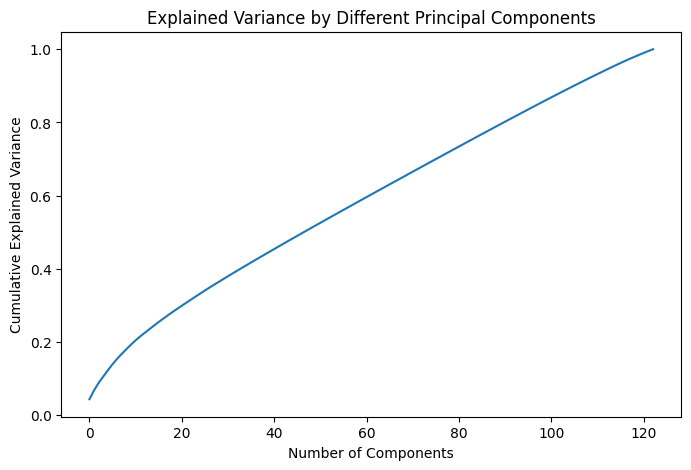

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming X_train is your training data after preprocessing but before PCA
pca = PCA().fit(X_train_pca)

# Plotting the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.show()


In [17]:
# Assuming 'pca' is already fitted to your data as shown above
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 95% of the variance
number_of_components = np.where(cumulative_variance_ratio >= 0.95)[0][0] + 1

print(f"Number of components explaining 95% variance: {number_of_components}")


Number of components explaining 95% variance: 114


**xxxxxxxxxxxxxxxxxxxxxxxxxxx   Final Model with the best accuracy   xxxxxxxxxxxxxxxxxxxxxxxxxx**

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

def preprocess_data(data, scaler_obj=None, pca_obj=None, n_components=None, train_columns=None):
    # Separate the numeric and categorical columns
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    categorical_columns = data.select_dtypes(exclude=[np.number]).columns

    # Impute numeric columns with the median
    numeric_imputer = SimpleImputer(strategy='median')
    data[numeric_columns] = numeric_imputer.fit_transform(data[numeric_columns])

    # Impute categorical columns with the mode
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    data[categorical_columns] = categorical_imputer.fit_transform(data[categorical_columns])

    # Now we can use linear regression to impute any remaining missing values in numeric columns
    for column in numeric_columns:
        if data[column].isnull().any():
            # Your predictors will be all other numeric columns
            predictors = data[numeric_columns].drop(columns=[column])
            # Your response variable will be the column with missing values
            target = data[column]
            # Use rows where the target is not missing to train the model
            reg = LinearRegression()
            reg.fit(predictors[target.notnull()], target[target.notnull()])
            # Predict and fill missing values only in rows where the target is missing
            data.loc[target.isnull(), column] = reg.predict(predictors[target.isnull()])

    # Ensure the index is the same as the original data
    data.index = data.index
    
    
    # 7. Flagged Document Interactions
    document_cols = [col for col in data.columns if col.startswith('FLAG_DOCUMENT')]
    data['NUM_FLAGGED_DOCUMENTS'] = data[document_cols].sum(axis=1)

    # Separate TARGET before scaling
    y = None
    if 'TARGET' in data:
        y = data['TARGET']
        data = data.drop(['TARGET'], axis=1)

    # One-hot Encoding
    data_encoded = pd.get_dummies(data, drop_first=True)

    # Ensure the test dataset has the same columns as the training dataset
    if train_columns is not None:
        data_encoded = data_encoded.reindex(columns=train_columns, fill_value=0)

    # Scaling
    if not scaler_obj:
        scaler_obj = StandardScaler()
        data_scaled = pd.DataFrame(scaler_obj.fit_transform(data_encoded), columns=data_encoded.columns)
    else:
        data_scaled = pd.DataFrame(scaler_obj.transform(data_encoded), columns=train_columns)

    # Apply PCA
    if n_components:
        if not pca_obj:
            pca_obj = PCA(n_components=n_components)
            principalComponents = pca_obj.fit_transform(data_scaled)
        else:
            principalComponents = pca_obj.transform(data_scaled)

        # Create a DataFrame with the principal components
        columns = ['principal_component_' + str(i+1) for i in range(principalComponents.shape[1])]
        principalDf = pd.DataFrame(principalComponents, columns=columns)
        data_pca = principalDf
    else:
        data_pca = data_scaled

    return data_pca, y, scaler_obj, pca_obj, train_columns if train_columns is not None else data_encoded.columns


In [41]:
train_set, test_set = train_test_split(train_data, test_size=0.2, random_state=42)

# Assuming preprocess_data is the function we discussed earlier
number_of_components = 123  #number of components you determined is best

# Preprocess the training data
X_train_pca, y_train, scaler, pca, train_columns = preprocess_data(train_set, n_components=number_of_components)

# Preprocess the test data using the same scaler and PCA objects
X_test_pca, y_test, _, _, _ = preprocess_data(test_set, scaler_obj=scaler, pca_obj=pca, n_components=number_of_components, train_columns=train_columns)


In [43]:
# Define the best parameters after hyperopt 
best_params = {
    'C': 6.992697684988856,
    'max_iter': 2000,
    'penalty': 'l2',
    'solver': 'liblinear'
}

# Create a logistic regression model with the best parameters
logreg_best = LogisticRegression(**best_params)

# Fit the model on the training data with PCA applied
logreg_best.fit(X_train_pca, y_train)

# Predict on the test set with PCA applied
y_test_pred = logreg_best.predict(X_test_pca)

# Calculate the performance metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Output the performance
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.676363208102697
Precision: 0.6686715481171548
Recall: 0.633234274393264
F1 Score: 0.6504706181633172


In [18]:
# Final prediction on validation dataset (UnknownDataset)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming preprocess_data is the function we discussed earlier

number_of_components = 123# or whatever number of components you determined is best


# Preprocess the training data
X_train_pca, y_train, scaler, pca, train_columns = preprocess_data(train_data, n_components=number_of_components)

# Preprocess the validation data using the same scaler and PCA objects
X_val_pca, y_val, _, _, _ = preprocess_data(test_data, scaler_obj=scaler, pca_obj=pca, n_components=number_of_components, train_columns=train_columns)


# Define the best parameters
best_params = {
    'C': 6.992697684988856,
    'max_iter': 2000,
    'penalty': 'l2',
    'solver': 'liblinear'
}

# Create a logistic regression model with the best parameters
logreg_best = LogisticRegression(**best_params)

# Fit the model on the training data with PCA applied
logreg_best.fit(X_train_pca, y_train)

# Predict on the validation set with PCA applied
y_val_pred = logreg_best.predict(X_val_pca)

Accuracy: 0.676363208102697
Precision: 0.6686715481171548
Recall: 0.633234274393264
F1 Score: 0.6504706181633172
Confusion Matrix:
[[3186 1267]
 [1481 2557]]


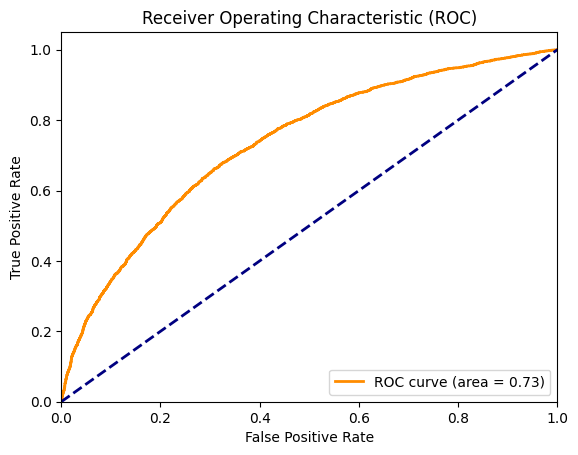

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

# Assuming X_train_pca, X_test_pca, y_train, and y_test are already defined

# Define the best parameters after hyperopt
best_params = {
    'C': 6.992697684988856,
    'max_iter': 2000,
    'penalty': 'l2',
    'solver': 'liblinear'
}

# Create a logistic regression model with the best parameters
logreg_best = LogisticRegression(**best_params)

# Fit the model on the training data with PCA applied
logreg_best.fit(X_train_pca, y_train)

# Predict on the test set with PCA applied
y_test_pred = logreg_best.predict(X_test_pca)
y_test_pred_proba = logreg_best.predict_proba(X_test_pca)[:, 1]  # Probability predictions for ROC curve

# Calculate the performance metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Output the performance
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
